From notes:
Model options include SVM, linear/logistic, naive bayes, GDA

Acceptable
Logreg solvers: newton-cholesky (Newton's method), liblinear (coordinate descent)

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
from datetime import datetime
try:
    import winsound
except:
    print("No beep")

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from scipy.stats import loguniform

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB


In [3]:
# Utility functions
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be changed.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def start_timer():
    global start_time
    start_time = datetime.now()
    print('Start time: ', start_time.strftime('%H:%M:%S'))

def end_timer():
    end_time = datetime.now()
    print('End time: ', end_time.strftime('%H:%M:%S'))
    runtime = end_time - start_time
    print('Runtime: ', runtime,'\n')

def beep_when_done():
    duration = 300  # milliseconds
    freq = 440  # Hz
    try:
        winsound.Beep(freq, duration)
    except:
        print("Beep! (Sound not working)")


In [4]:
# For default models
def fit_eval(clf, name, normalize=True):
    """
    Fit a (preprocess -> model) pipeline and evaluate on a held-out test split.

    Parameters
    ----------
    clf : sklearn estimator
        The classifier to evaluate. It will be wrapped in a Pipeline along with `preprocess`.
        Example: LogisticRegression(...), SGDClassifier(...), etc.
    name : str
        Label used in printed headers so you can tell runs apart.
    normalize : bool, default=True
        If True, show a row-normalized confusion matrix (each row sums to 1) in the plot.
        Useful for imbalanced data to see per-class recall at a glance.

    Notes
    -----
    - Splits once (stratified) to keep class balance in train/test.
    - Uses the estimator's *default* decision rule:
        * proba-based models: threshold = 0.5 on predict_proba[:, 1]
        * margin-based models: threshold = 0.0 on decision_function
      That choice strongly affects precision/recall. Tune threshold later if needed.
    - Computes both ROC-AUC and PR-AUC. PR-AUC is often more informative with imbalance.
    """

    # Build the end-to-end pipeline:
    #   preprocess -> (scale numeric, passthrough binary, etc.)
    #   model      -> the estimator you pass in
    pipe = Pipeline([("prep", preprocess), ("model", clf)])

    # Single stratified split keeps the positive rate similar in train/test.
    # NOTE: If you grid-search elsewhere, ensure the split there is separate to avoid leakage.
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Fit pipeline on the training portion only (prevents data leakage in scaling).
    pipe.fit(X_tr, y_tr)

    # Default decision rule:
    #   predict() applies internal threshold (0.5 for proba models, 0.0 for margins).
    y_pred = pipe.predict(X_te)

    # Basic classification report (precision/recall/F1 per class + averages).
    print(f"\n=== {name} : classification_report (default threshold) ===")
    print(metrics.classification_report(y_te, y_pred, digits=3))

    # Confusion matrix in counts for sanity; the plot function can normalize visually.
    cm = metrics.confusion_matrix(y_te, y_pred)
    plot_confusion_matrix(cm, ['No diabetes', 'Diabetes'], normalize)

    # ---- Discrimination metrics (use scores, not hard labels) ----
    # Prefer probabilities when available; otherwise use decision_function scores.
    if hasattr(pipe.named_steps["model"], "predict_proba"):
        y_proba = pipe.predict_proba(X_te)[:, 1]  # P(y=1 | x)
        roc = metrics.roc_auc_score(y_te, y_proba)
        pr  = metrics.average_precision_score(y_te, y_proba)  # PR-AUC (Average Precision)
    elif hasattr(pipe.named_steps["model"], "decision_function"):
        scores = pipe.decision_function(X_te)      # larger = more likely positive
        roc = metrics.roc_auc_score(y_te, scores)
        pr  = metrics.average_precision_score(y_te, scores)
    else:
        # Some estimators don’t expose either; skip AUCs gracefully.
        roc = pr = None

    if roc is not None:
        print(f"ROC-AUC: {roc:.3f}")
        print(f"PR-AUC : {pr:.3f}")

    # Optional: return items for programmatic use (e.g., to compare across models)
    # return {
    #     "name": name,
    #     "estimator": pipe,
    #     "y_true": y_te,
    #     "y_pred": y_pred,
    #     "roc_auc": roc,
    #     "pr_auc": pr,
    #     "confusion_matrix": cm
    # }

In [5]:
# For tuned models
def eval_pipeline(pipe, name, normalize_cm=True):
    """
    Evaluate a *fitted* pipeline (e.g., best_estimator_ from CV) on the held-out test set.

    Parameters
    ----------
    pipe : sklearn Pipeline
        A trained pipeline, typically the `best_estimator_` returned by
        RandomizedSearchCV/GridSearchCV. Expected to contain:
          - "prep": your preprocessing transformer (scaling, passthrough, etc.)
          - "model": the tuned classifier
        NOTE: Do not refit here; this function only evaluates on X_te/y_te.
    name : str
        Name to show in the printed header (e.g., "Logistic Regression (tuned)").
    normalize_cm : bool, default=True
        If True, your plotting helper should render a normalized confusion matrix.
        Normalization (row-wise) makes per-class recall visually comparable in imbalanced data.

    Notes
    -----
    - `.predict()` applies the model's default decision rule:
        * Probability-based models: threshold = 0.5 on predict_proba[:, 1].
        * Margin-based models: threshold = 0.0 on decision_function.
      This choice drives the precision/recall trade-off you see below.
    - We also report ROC-AUC and PR-AUC using *scores* (probas or margins),
      which are threshold-independent summaries of ranking quality.
    - Ensure X_te / y_te are a true hold-out set that was *not* used in tuning
      (to avoid optimistic estimates).
    """

    # Hard predictions at the model's default threshold 0.5
    y_pred = pipe.predict(X_te)

    # Per-class precision/recall/F1 plus macro/weighted averages
    print(f"\n=== {name} (best params) ===")
    print(metrics.classification_report(y_te, y_pred, digits=3))

    # Confusion matrix in counts for a concrete error breakdown
    cm = metrics.confusion_matrix(y_te, y_pred)
    print("Confusion matrix (counts):\n", cm)

    # Your helper draws counts or normalized CM depending on normalize_cm
    # Label order should match your y encoding: 0 = 'No diabetes', 1 = 'Diabetes'
    plot_confusion_matrix(cm, ['No diabetes','Diabetes'], normalize_cm)

    # ---- Threshold-independent metrics (use continuous scores) ----
    # Prefer probabilities if available; otherwise fall back to decision_function
    if hasattr(pipe.named_steps["model"], "predict_proba"):
        scores = pipe.predict_proba(X_te)[:, 1]   # P(y=1 | x)
    elif hasattr(pipe.named_steps["model"], "decision_function"):
        scores = pipe.decision_function(X_te)     # larger => more positive
    else:
        # Some estimators expose neither; gracefully skip AUCs
        print("Estimator has neither predict_proba nor decision_function; skipping AUCs.")
        return

    # ROC-AUC: ranking quality vs. FPR; PR-AUC (Average Precision): better for imbalance
    print(f"ROC-AUC: {metrics.roc_auc_score(y_te, scores):.3f}")
    print(f"PR-AUC : {metrics.average_precision_score(y_te, scores):.3f}")

    # Optional: return values for programmatic comparison
    # return {
    #     "name": name,
    #     "y_true": y_te,
    #     "y_pred": y_pred,
    #     "confusion_matrix": cm,
    #     "roc_auc": metrics.roc_auc_score(y_te, scores),
    #     "pr_auc": metrics.average_precision_score(y_te, scores),
    # }

In [6]:
data1_filename = "diabetes_binary_health_indicators_BRFSS2015.csv"
df1 = pd.read_csv(data1_filename)

# Taken from datacard on Kaggle, augmented by descriptions given in primary source.

column_descriptions = {
    'Diabetes_binary':"0 = no diabetes 1 = diabetes",
     'HighBP':"0 = no high BP 1 = high BP",
     'HighChol':"0 = no high cholesterol 1 = high cholesterol",
     'CholCheck':"0 = no cholesterol check in 5 years 1 = yes cholesterol check in 5 years",
     'BMI':"Body Mass Index",
     'Smoker':"Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes] 0 = no 1 = yes",
     'Stroke':"(Ever told) you had a stroke. 0 = no 1 = yes",
     'HeartDiseaseorAttack':"coronary heart disease (CHD) or myocardial infarction (MI) 0 = no 1 = yes",
     'PhysActivity':"physical activity in past 30 days - not including job 0 = no 1 = yes",
     'Fruits':"Consume Fruit 1 or more times per day 0 = no 1 = yes ",
     'Veggies':"Consume Vegetables 1 or more times per day 0 = no 1 = yes",
     'HvyAlcoholConsump':"Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week) 0 = no",
     'AnyHealthcare':"Have any kind of health care coverage, including health insurance, prepaid plans such as HMO, etc. 0 = no 1 = yes",
     'NoDocbcCost':"Was there a time in the past 12 months when you needed to see a doctor but could not because of cost? 0 = no 1 = yes",
     'GenHlth':"Would you say that in general your health is: scale 1-5 1 = excellent 2 = very good 3 = good 4 = fair 5 = poor",
     'MentHlth':"Now thinking about your mental health, which includes stress, depression, and problems with emotions, for how many days during the past 30 days was your mental health not good? scale 1-30 days",
     'PhysHlth':"Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good? scale 1-30 days",
     'DiffWalk':"Do you have serious difficulty walking or climbing stairs? 0 = no 1 = yes",
     'Sex':"0 = female 1 = male",
     'Age':"13-level age category (_AGEG5YR see codebook) 1 = 18-24, 2 = 25-29, 3 = 30-34, etc, 9 = 60-64, 13 = 80 or older",
     'Education':"Education level (EDUCA see codebook) scale 1-6 1 = Never attended school or only kindergarten 2 = Grades 1 through 8 (Elementary) 3 = Grades 9 through 11 (Some high school) 4 = Grade 12 or GED (High school graduate) 5 = College 1 year to 3 years (Some college or technical school) 6 = College 4 years or more (College graduate)",
     'Income':"Income scale (INCOME2 see codebook) scale 1-8. 1 = less than $10k, 2 = less than $15k, 3 = less than $20k, 4 = less than $25k, 5 = less than $35k, 6 = less than $50k, 7 = less than $75k, 8 = $75k or more"
}

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [24]:
df1.head(10)

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
5,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,2.0,0.0,1.0,10.0,6.0,8.0
6,0.0,1.0,0.0,1.0,30.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,3.0,0.0,14.0,0.0,0.0,9.0,6.0,7.0
7,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,0.0,0.0,1.0,0.0,11.0,4.0,4.0
8,1.0,1.0,1.0,1.0,30.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,5.0,30.0,30.0,1.0,0.0,9.0,5.0,1.0
9,0.0,0.0,0.0,1.0,24.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,2.0,0.0,0.0,0.0,1.0,8.0,4.0,3.0


In [9]:
# df1.nunique()

In [10]:
# ---- Target/feature split ----
# Diabetes_binary is already 0/1; cast to int to avoid bool dtype surprises downstream.
y = df1["Diabetes_binary"].astype(int)
X = df1.drop(columns=["Diabetes_binary"])

# ---- Column typing ----
# Treat columns whose unique (non-null) values are subset of {0,1} as binary features.
# Everything else is assumed continuous numeric.
# NOTE: If you have categorical strings, they won't appear here—add a OneHotEncoder branch if needed.
binary_cols = [c for c in X.columns if set(pd.unique(X[c].dropna())) <= {0, 1}]
numeric_cols = [c for c in X.columns if c not in binary_cols]

# Ensure binary features are ints (not bools/floats), which keeps them 0/1 through the pipeline.
for c in binary_cols:
    X[c] = X[c].astype(int)

# ---- Hold-out split ----
# Stratified split preserves the positive rate (~class imbalance) in both train and test.
# random_state for reproducibility; keep this consistent across experiments.
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---- Preprocessing pipeline ----
# Scale only the continuous features (helps linear/SGD solvers); pass binary 0/1 through unchanged.
# 'remainder="drop"' ensures only specified columns flow downstream, preventing accidental leakage.
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("bin", "passthrough", binary_cols),
    ],
    remainder="drop",
)

# ---- Cross-validation plan ----
# StratifiedKFold maintains class proportions in each fold—crucial for stable metrics on imbalanced data.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [11]:
# ---- Scoring choice (very important) ----
# Use 'recall' to prioritize catching positives (Diabetes=1).
# This aligns model selection with goal of minimizing false negatives (within reason).
# Alternatives to consider:
#   - 'f1' or a custom F-beta (beta=1.5 or 2 via make_scorer) to trade some recall for precision.
#   - 'average_precision' (PR-AUC) for threshold-independent ranking quality during tuning,
#     combined with recall-focused evaluation at the default 0.5 threshold.

fbeta = metrics.make_scorer(metrics.fbeta_score, beta=2.0)

# scoring = "recall"
scoring = fbeta



=== Logistic Regression : classification_report (default threshold) ===
              precision    recall  f1-score   support

           0      0.949     0.727     0.823     43667
           1      0.311     0.761     0.441      7069

    accuracy                          0.732     50736
   macro avg      0.630     0.744     0.632     50736
weighted avg      0.860     0.732     0.770     50736



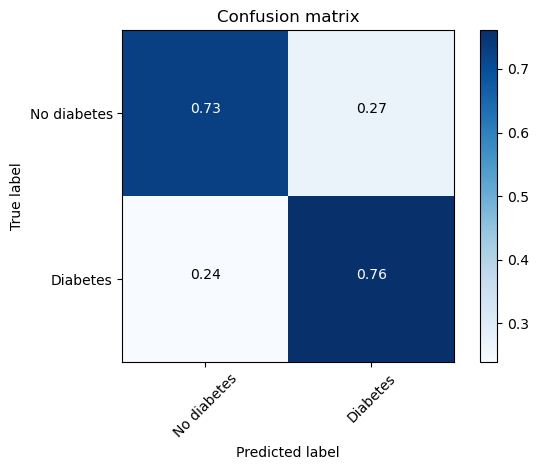

ROC-AUC: 0.820
PR-AUC : 0.393


In [21]:
# Fixed model parameters
logreg = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    class_weight="balanced",
    max_iter=1000
)


fit_eval(logreg, "Logistic Regression")

Start time:  18:21:50
LogReg best CV score [fbeta_score]: 0.593
LogReg best params: {'model__solver': 'liblinear', 'model__penalty': 'l2', 'model__class_weight': 'balanced', 'model__C': np.float64(6.158482110660261)}

=== Logistic Regression (tuned) (best params) ===
              precision    recall  f1-score   support

           0      0.949     0.727     0.823     43667
           1      0.311     0.761     0.441      7069

    accuracy                          0.732     50736
   macro avg      0.630     0.744     0.632     50736
weighted avg      0.860     0.732     0.770     50736

Confusion matrix (counts):
 [[31737 11930]
 [ 1690  5379]]


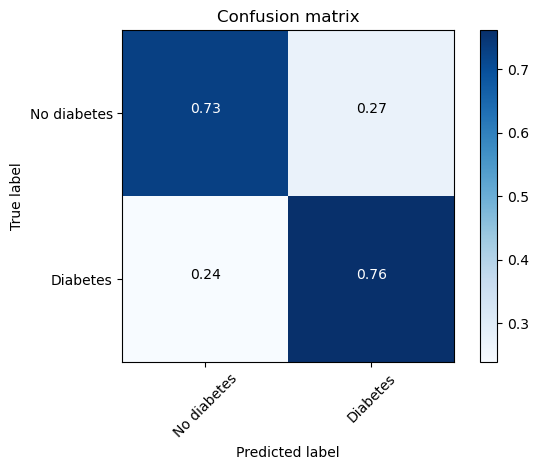

ROC-AUC: 0.820
PR-AUC : 0.393
End time:  18:24:06
Runtime:  0:02:16.507262 



In [27]:
# ---------- 1) Logistic Regression: RandomizedSearchCV ----------
# Tuning LR inside a full pipeline so preprocessing happens *inside* CV folds (no leakage).

start_timer()

logreg_base = Pipeline([
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=2000))
])

# Candidate C values on a log scale (0.001 .. 10). Wider coverage is usually better than linear steps.
log_C = list(np.logspace(-3, 1, 20))

# Use a *list of dicts* to restrict to valid solver/penalty combos:
#   - liblinear supports L1/L2; fast for small/medium tabular data
#   - newton-cholesky supports L2
# Class weight is fixed to "balanced" here to keep recall higher at default threshold.
logreg_param_distributions = [
    {
        "model__solver": ["liblinear"],
        "model__penalty": ["l1", "l2"],
        "model__C": log_C,
        "model__class_weight": ["balanced", None]
    },
    {
        "model__solver": ["newton-cholesky"],
        "model__penalty": ["l2"],
        "model__C": log_C,
        "model__class_weight": ["balanced", None]
    }
]

# RandomizedSearchCV samples parameter settings at random; great when the space is large.
# - scoring comes from your earlier choice (e.g., "recall", "f1", or a custom F-beta).
# - refit=True means the best model (by 'scoring') is retrained on the full training set.
# - n_jobs=-1 uses all CPU cores.
logreg_rs = RandomizedSearchCV(
    estimator=logreg_base,
    param_distributions=logreg_param_distributions,
    n_iter=10,                 # increase for a wider search; reduce if runtime is long
    scoring=scoring,           # IMPORTANT: ensure this matches objective (e.g., "recall" or "f1")
    cv=cv,
    n_jobs=-1,
    refit=True,
    random_state=42,
    verbose=0
)

# Fit on training fold data only; preprocessing occurs within each CV split properly.
logreg_rs.fit(X_tr, y_tr)


label = (scoring if isinstance(scoring, str)
         else (logreg_rs.refit if isinstance(scoring, dict)
               else getattr(scoring, "_score_func", scoring).__name__))
print(f"LogReg best CV score [{label}]: {logreg_rs.best_score_:.3f}")
print("LogReg best params:", logreg_rs.best_params_)

# Evaluate the *refit* best pipeline on the held-out test set (true generalization check).
eval_pipeline(logreg_rs.best_estimator_, "Logistic Regression (tuned)")

end_timer()
beep_when_done()


=== SGDClassifier : classification_report (default threshold) ===
              precision    recall  f1-score   support

           0      0.938     0.756     0.837     43667
           1      0.315     0.694     0.434      7069

    accuracy                          0.747     50736
   macro avg      0.627     0.725     0.636     50736
weighted avg      0.852     0.747     0.781     50736



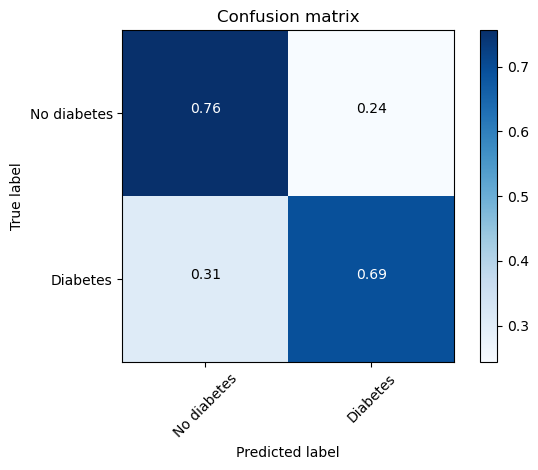

ROC-AUC: 0.803
PR-AUC : 0.366


In [29]:
# Fixed model parameters

SGDClass = SGDClassifier(
    loss="log_loss",          
    class_weight="balanced",
    max_iter=5000,
    tol=1e-4,
    alpha=1e-5,                
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=10,
    random_state=42
)

fit_eval(SGDClass, "SGDClassifier")

Start time:  18:24:40
SGD best CV score [fbeta_score]: 0.580
SGD best params: {'model__validation_fraction': 0.15, 'model__tol': 0.001, 'model__penalty': 'elasticnet', 'model__n_iter_no_change': 15, 'model__max_iter': 2000, 'model__loss': 'log_loss', 'model__l1_ratio': 0.15, 'model__early_stopping': True, 'model__class_weight': 'balanced', 'model__alpha': 1e-05}

=== SGDClassifier (tuned) (best params) ===
              precision    recall  f1-score   support

           0      0.933     0.776     0.847     43667
           1      0.322     0.657     0.432      7069

    accuracy                          0.759     50736
   macro avg      0.627     0.716     0.640     50736
weighted avg      0.848     0.759     0.789     50736

Confusion matrix (counts):
 [[33883  9784]
 [ 2428  4641]]


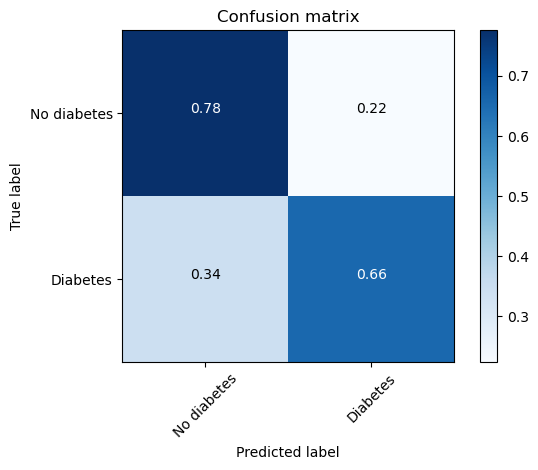

ROC-AUC: 0.800
PR-AUC : 0.360
End time:  18:24:51
Runtime:  0:00:10.422554 



In [31]:
# ---------- 2) SGDClassifier: RandomizedSearchCV  ----------
# Tune a linear classifier trained with (stochastic) gradient descent.
# Keeping preprocessing inside the pipeline avoids leakage during CV.

start_timer()

sgd_base = Pipeline([
    ("prep", preprocess),
    ("model", SGDClassifier(random_state=42))
])

# Parameter space:
# - loss: 'log_loss' gives probabilities; 'modified_huber' is robust; 'hinge' is SVM-like (no proba).
# - alpha: L2 regularization strength (λ); smaller -> weaker regularization (can boost recall but risk overfit).
# - penalty: choose regularizer type; 'elasticnet' blends L1/L2 using l1_ratio.
# - early_stopping: monitors a validation split and stops when no improvement.
# - class_weight='balanced': counteracts class imbalance (keeps recall from collapsing at default threshold).
sgd_param_dist = {
    "model__loss": ["log_loss", "perceptron", "hinge"],
    "model__alpha": [1e-6, 3e-6, 1e-5, 3e-5, 1e-4],
    "model__penalty": ["l2", "l1", "elasticnet"],
    "model__l1_ratio": [0.0, 0.15, 0.5, 0.9],  # only used when penalty='elasticnet'
    "model__max_iter": [2000, 4000, 6000],
    "model__tol": [1e-4, 1e-3],
    "model__class_weight": ["balanced"],
    "model__early_stopping": [True],          # lets SGD pick iterations automatically
    "model__validation_fraction": [0.1, 0.15, 0.2],
    "model__n_iter_no_change": [5, 10, 15],
}

# RandomizedSearchCV samples combos at random (good for larger spaces).
# - scoring comes from your earlier choice (e.g., 'recall', 'f1', or custom F-beta).
# - refit=True retrains the best setting on the full training data.
sgd_rs = RandomizedSearchCV(
    estimator=sgd_base,
    param_distributions=sgd_param_dist,
    n_iter=10,
    scoring=scoring,     # IMPORTANT: aligns with your objective at default threshold
    cv=cv,
    n_jobs=-1,
    refit=True,
    random_state=42,
    verbose=0
)

# Fit the randomized search on the training split; preprocessing happens within each CV fold.
sgd_rs.fit(X_tr, y_tr)

# Report best CV score with the actual scoring name used
label = (scoring if isinstance(scoring, str)
         else (sgd_rs.refit if isinstance(scoring, dict)
               else getattr(scoring, "_score_func", scoring).__name__))
print(f"SGD best CV score [{label}]: {sgd_rs.best_score_:.3f}")

print("SGD best params:", sgd_rs.best_params_)

# ---------- Evaluate best estimator on the held-out test set ----------
# Uses your eval helper; this keeps threshold at the model's default (0.5 or 0.0 margin).
eval_pipeline(sgd_rs.best_estimator_, "SGDClassifier (tuned)")

end_timer()
beep_when_done()


Start time:  18:38:56

=== LinearSVC (Fixed Params) : classification_report (default threshold) ===
              precision    recall  f1-score   support

           0      0.951     0.721     0.820     43667
           1      0.308     0.769     0.440      7069

    accuracy                          0.727     50736
   macro avg      0.629     0.745     0.630     50736
weighted avg      0.861     0.727     0.767     50736



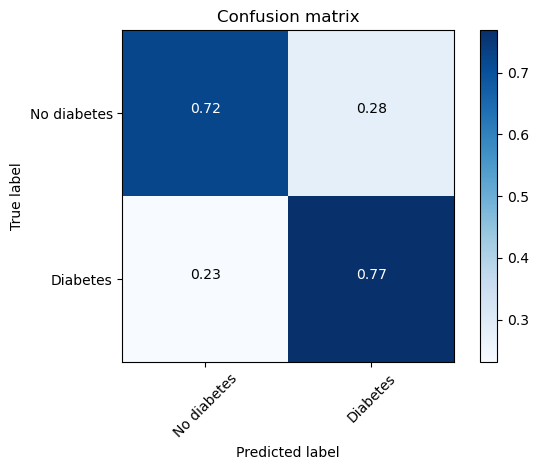

ROC-AUC: 0.819
PR-AUC : 0.394
End time:  18:38:58
Runtime:  0:00:01.874308 



In [26]:
# LinearSVC
# Choosing some initial parameters for C.
# class_weight='balanced' is important for imbalanced data.

start_timer()

lsvc_fixed = LinearSVC(
    C=1.0,        # Example C value
    class_weight='balanced',
    random_state=42,
    max_iter = 1000
)

fit_eval(lsvc_fixed, "LinearSVC (Fixed Params)")

end_timer()
beep_when_done()

Start time:  20:01:09
Fitting 5 folds for each of 2 candidates, totalling 10 fits
LinearSVC (RandomizedSearchCV)
Best params: {'model__C': np.float64(1.3145103232150122), 'model__class_weight': 'balanced', 'model__dual': False, 'model__loss': 'squared_hinge', 'model__tol': np.float64(0.0002051338263087451)}
Best mean CV score: 0.5938644575580911

=== LinearSVC (RS) (best params) ===
              precision    recall  f1-score   support

           0      0.951     0.721     0.820     43667
           1      0.308     0.769     0.440      7069

    accuracy                          0.727     50736
   macro avg      0.629     0.745     0.630     50736
weighted avg      0.861     0.727     0.767     50736

Confusion matrix (counts):
 [[31475 12192]
 [ 1636  5433]]


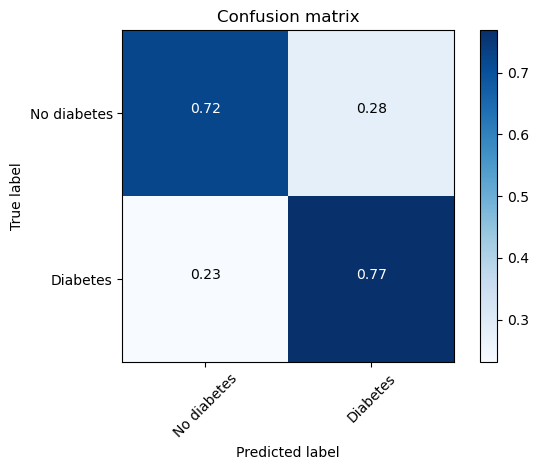

ROC-AUC: 0.819
PR-AUC : 0.394
End time:  20:01:18
Runtime:  0:00:09.351753 



In [44]:
start_timer()

# Pipeline: preprocess -> LinearSVC
# NOTE: step is named "model" so eval_pipeline() finds it
svc_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearSVC(class_weight="balanced", max_iter=20000))
])

# Convergence-friendly search space:
# - Prefer squared_hinge (lets us use dual=False, which often converges better when n_samples >> n_features)
# - Allow both dual settings; the CV will pick what works best
# - Narrow C to a saner band and use a slightly looser tol range
param_distributions = {
    "model__C":   loguniform(1e-3, 1e1),
    "model__tol": loguniform(1e-4, 1e-2),
    "model__loss": ["squared_hinge"],   # avoid invalid combos and favor convergence
    "model__dual": [False, True],
    "model__class_weight": ["balanced"] # keep fixed; remove None to reduce variance
}

svc_rs = RandomizedSearchCV(
    estimator=svc_pipe,
    param_distributions=param_distributions,
    n_iter=2,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    refit=True,
    verbose=1
)

svc_rs.fit(X_tr, y_tr)

print("LinearSVC (RandomizedSearchCV)")
print("Best params:", svc_rs.best_params_)
print("Best mean CV score:", svc_rs.best_score_)

# Evaluate on your held-out test split using the shared helper
eval_pipeline(svc_rs.best_estimator_, name="LinearSVC (RS)")

end_timer(); beep_when_done()

Start time:  13:10:25
Fitting 5 folds for each of 20 candidates, totalling 100 fits
GaussianNB (RandomizedSearchCV)
Best params: {'model__var_smoothing': np.float64(5.061576888752309e-07)}
Best mean CV score: 0.4957880687852324

=== GaussianNB (RS) (best params) ===
              precision    recall  f1-score   support

           0      0.919     0.806     0.859     43667
           1      0.320     0.564     0.408      7069

    accuracy                          0.772     50736
   macro avg      0.620     0.685     0.634     50736
weighted avg      0.836     0.772     0.796     50736

Confusion matrix (counts):
 [[35190  8477]
 [ 3083  3986]]


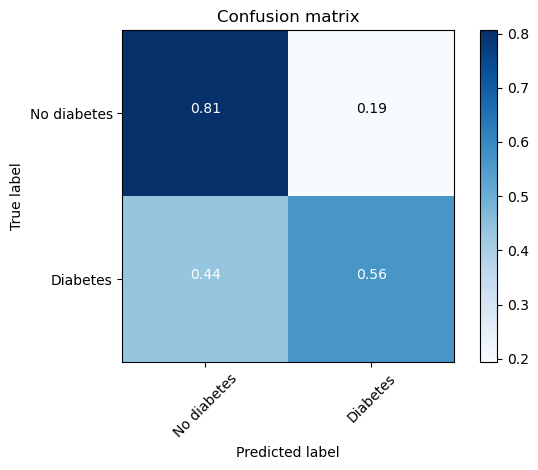

ROC-AUC: 0.780
PR-AUC : 0.335
End time:  13:10:34
Runtime:  0:00:08.855582 



In [32]:
start_timer()

# Pipeline: preprocess -> GaussianNB
# (Your existing `preprocess` scales numeric and passes binary through — fine for GNB.)
gnb_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", GaussianNB())
])

# Search space: var_smoothing controls numerical stability (log-scale)
param_distributions = {
    "model__var_smoothing": loguniform(1e-12, 1e-6),
    # Keep priors None; stratified CV handles imbalance. Add a fixed prior only if you must.
    # "model__priors": [None],
}

gnb_rs = RandomizedSearchCV(
    estimator=gnb_pipe,
    param_distributions=param_distributions,
    n_iter=20,            # adjust if you want quicker runs (e.g., 5)
    scoring=scoring,      # your F2 scorer
    cv=cv,                # your existing CV object (e.g., StratifiedKFold)
    n_jobs=-1,
    random_state=42,
    refit=True,
    verbose=1
)

gnb_rs.fit(X_tr, y_tr)

print("GaussianNB (RandomizedSearchCV)")
print("Best params:", gnb_rs.best_params_)
print("Best mean CV score:", gnb_rs.best_score_)

# Evaluate on your held-out test split using the shared helper
eval_pipeline(gnb_rs.best_estimator_, name="GaussianNB (RS)")

end_timer(); beep_when_done()

Start time:  13:14:39
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best LDA variant: LDA lsqr/eigen numeric shrinkage (RS)
Best params: {'model__shrinkage': np.float64(0.8324426408004217), 'model__solver': 'eigen'}
Best mean CV score: 0.44260102426239134

=== LDA lsqr/eigen numeric shrinkage (RS) (best params) ===
              precision    recall  f1-score   support

           0      0.909     0.871     0.889     43667
           1      0.366     0.461     0.408      7069

    accuracy                          0.814     50736
   macro avg      0.638     0.666     0.649     50736
weighted avg      0.833     0.814     0.822     50736

Confusion matrix (counts):
 [[38020  5647]
 [ 3808  3261]]


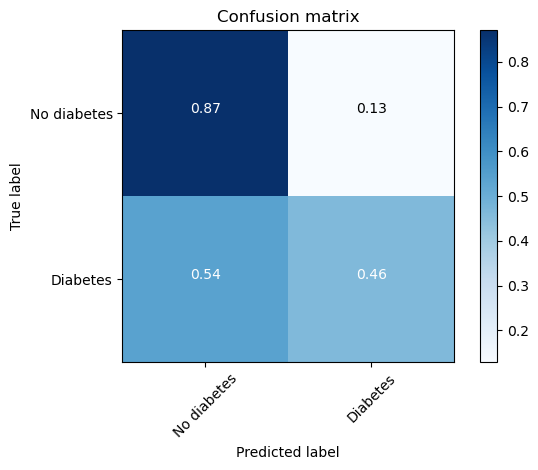

ROC-AUC: 0.799
PR-AUC : 0.359
End time:  13:15:03
Runtime:  0:00:24.496421 



In [40]:
# --- Linear Discriminant Analysis: robust tuning + evaluation ---
import numpy as np
from scipy.stats import uniform, loguniform
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

start_timer()

# Pipeline: preprocess -> LDA  (step named "model" so eval_pipeline works)
lda_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LDA())
])

# --- Search 1: 'svd' solver (shrinkage must be None; tune tol only) ---
svd_dist = {
    "model__solver": ["svd"],
    "model__shrinkage": [None],
    "model__tol": loguniform(1e-6, 1e-2),
}
lda_rs_svd = RandomizedSearchCV(
    estimator=lda_pipe,
    param_distributions=svd_dist,
    n_iter=15,                 # set lower (e.g., 5) for a quick pass
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    refit=True,
    verbose=1,
    error_score=np.nan,        # don't crash on occasional fold issues
)

# --- Search 2a: 'lsqr'/'eigen' with numeric shrinkage in [0,1] ---
le_num_dist = {
    "model__solver": ["lsqr", "eigen"],
    "model__shrinkage": uniform(0.0, 1.0),  # float shrinkage
}
lda_rs_le_num = RandomizedSearchCV(
    estimator=lda_pipe,
    param_distributions=le_num_dist,
    n_iter=15,                 # set lower (e.g., 5) for a quick pass
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    refit=True,
    verbose=1,
    error_score=np.nan,
)

# --- Search 2b: 'lsqr'/'eigen' with shrinkage='auto' (grid is fine) ---
le_auto_grid = {
    "model__solver": ["lsqr", "eigen"],
    "model__shrinkage": ["auto"],
}
lda_gs_le_auto = GridSearchCV(
    estimator=lda_pipe,
    param_grid=le_auto_grid,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=1,
    error_score=np.nan,
)

# ---- Run all searches on your train split ----
lda_rs_svd.fit(X_tr, y_tr)
lda_rs_le_num.fit(X_tr, y_tr)
lda_gs_le_auto.fit(X_tr, y_tr)

# ---- Pick the global best by CV score ----
candidates = [
    ("LDA svd (RS)", lda_rs_svd),
    ("LDA lsqr/eigen numeric shrinkage (RS)", lda_rs_le_num),
    ("LDA lsqr/eigen shrinkage=auto (GS)", lda_gs_le_auto),
]
best_name, best_search = max(candidates, key=lambda t: t[1].best_score_)

print(f"Best LDA variant: {best_name}")
print("Best params:", best_search.best_params_)
print("Best mean CV score:", best_search.best_score_)

# ---- Evaluate on your held-out test split ----
eval_pipeline(best_search.best_estimator_, name=f"{best_name}")

end_timer(); beep_when_done()
